In [1]:
import glob
import os
import json

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import cPickle as pkl


from pipeline.python.classifications import experiment_classes as util


import scipy.stats as spstats

from pipeline.python.utils import label_figure, natural_keys
from pipeline.python.classifications import bootstrap_fit_tuning_curves as osi
from pipeline.python.classifications import get_dataset_stats as gd

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

In [2]:
from scipy.spatial.distance import pdist, squareform


from sklearn.linear_model import LinearRegression
import scipy.stats as spstats
import sklearn.metrics as skmetrics #import mean_squared_error

def fit_linear_regr(xvals, yvals, return_regr=False):
    regr = LinearRegression()
    if len(xvals.shape) == 1:
        xvals = np.array(xvals).reshape(-1, 1)
        yvals = np.array(yvals).reshape(-1, 1)
    else:
        xvals = np.array(xvals)
        yvals = np.array(yvals)
    regr.fit(xvals, yvals)
    fitv = regr.predict(xvals)
    if return_regr:
        return fitv.reshape(-1), regr
    else:
        return fitv.reshape(-1)


In [3]:
%matplotlib notebook

In [4]:
reload(gd)

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juliana

<module 'pipeline.python.classifications.get_dataset_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/get_dataset_stats.pyc'>

# Get dataset info

In [5]:
options = ['-t', 'traces001']

optsE = gd.extract_options(options)


rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
state  = optsE.state
response_type = optsE.response_type
print response_type
print aggregate_dir

dff
/n/coxfs01/julianarhee/aggregate-visual-areas


In [6]:
sdata = gd.get_dataset_info(aggregate_dir=aggregate_dir, traceid=traceid,
                           fov_type=fov_type, state=state)

In [7]:
sdata.head()

,animalid,experiment,fov,session,visual_area,exp_no,animal_no
0,JC084,rfs,FOV1_zoom2p0x,20190522,V1,3,4
1,JC084,gratings,FOV1_zoom2p0x,20190522,V1,1,4
2,JC084,blobs,FOV1_zoom2p0x,20190522,V1,0,4
3,JC084,retino,FOV1_zoom2p0x,20190522,V1,2,4
4,JC084,rfs,FOV1_zoom2p0x,20190525,Lm,3,4


# Set responsivity params

In [8]:
responsive_test = 'nstds'
responsive_thr = 10
n_stds = 2.5

stats_desc = util.get_stats_desc(traceid=traceid, responsive_test=responsive_test, 
                    responsive_thr=responsive_thr, n_stds=n_stds)

# Look at 1 session first

In [97]:
animalid = 'JC084'
session = '20190522'
fov = 'FOV1_zoom2p0x'
experiment = 'gratings'

#### Get responsive cells

In [98]:
S = util.Session(animalid, session, fov)
all_rois = S.get_all_responsive_cells(traceid=traceid, response_type=response_type,
                                      responsive_test=responsive_test, responsive_thr=responsive_thr, fit_thr=0.5)


[JC084] 20190522 - FOV1_zoom2p0x:  Getting anatomicals...
... Found 1 anatomical runs.
... Getting screen info
... [JC084|20190522|FOV1_zoom2p0x] creating rfs object
... getting data paths - name: rfs
... renaming experiment to run name: combined_rfs_static
... checking for RF fits: fit-2dgaus_dff-no-cutoff
... loading RF fits (response-type: dff)
... got rf fits
... [JC084|20190522|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... renaming experiment to run name: combined_gratings_static
... getting responsive cells (test: nstds, thr: 10.00')
traces001
... [JC084|20190522|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... renaming experiment to run name: combined_blobs_static
... getting responsive cells (test: nstds, thr: 10.00')
--> [retino] not implemented


#### Load data

In [99]:
# Just look at 1 experiment for now
stats = S.experiments[experiment].get_trial_metrics() #ex.get_trial_metrics()

... loading data array
... offset: 644.22
... adjusting for equal reps / condn...


#### Cell-to-cell correlations across all trials

In [100]:
tstats = stats[roi_list]

In [101]:
tstats.shape

(1088, 127)

<IPython.core.display.Javascript object>


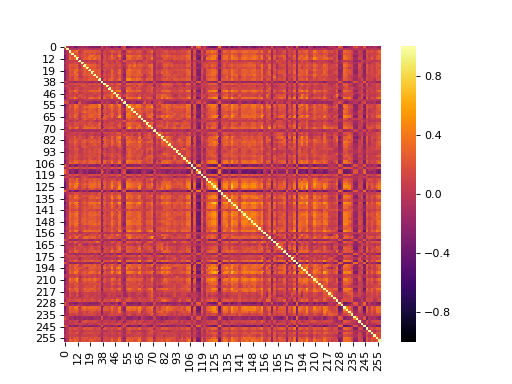

In [102]:
corr = tstats.corr()
pl.figure()
sns.heatmap(corr, cmap='inferno', vmin=-1, vmax=1)

# Get position info

In [9]:

pos_fpath = glob.glob(os.path.join(aggregate_dir, 'roi_positions.pkl'))[0]
with open(pos_fpath, 'rb') as f:
    fovinfo = pkl.load(f)
posdf = fovinfo['positions']
fovinfo.keys()

['positions', 'ap_lim', 'ml_lim', 'dims']

In [10]:
posdf = fovinfo['positions']

In [11]:
posdf.head()

,index,ap_pos,ml_pos,visual_area,animalid,session,fov
0,0,134.358419,961.493918,Li,JC076,20190422,FOV1_zoom2p0x
1,1,71.812258,938.601205,Li,JC076,20190422,FOV1_zoom2p0x
2,2,60.229636,930.970301,Li,JC076,20190422,FOV1_zoom2p0x
3,3,141.307992,938.601205,Li,JC076,20190422,FOV1_zoom2p0x
4,4,213.120250,944.324384,Li,JC076,20190422,FOV1_zoom2p0x


#### Get subst of position for current dataset and cells

In [12]:
currpos = posdf.groupby(['animalid', 'session', 'fov']).get_group((animalid, session, fov))
currpos = currpos[currpos['index'].isin(roi_list)]
currpos.index = currpos['index']
_ =currpos.pop('index')
currpos = currpos[['ap_pos', 'ml_pos']]


NameError: name 'animalid' is not defined

### Double-check FOV position

<IPython.core.display.Javascript object>


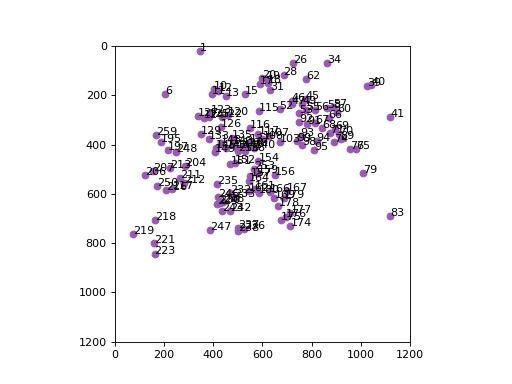

In [362]:
fig, ax = pl.subplots() #pl.figure()
ax.scatter(currpos['ap_pos'], currpos['ml_pos'])
for i in roi_list:
    xc = currpos['ap_pos'][i]
    yc = currpos['ml_pos'][i]
    ax.text(xc, yc, '%i' % int(i+1))
#ax.invert_yaxis()
ax.set_xlim([0, 1200])
ax.set_ylim([1200, 0])
ax.set_aspect('equal')

#### Visualize distance matrix

In [174]:
dist_matrix = squareform(pwdists)


In [364]:
dist_matrix = pd.DataFrame(dist_matrix, index=roi_list, columns=roi_list)

<IPython.core.display.Javascript object>


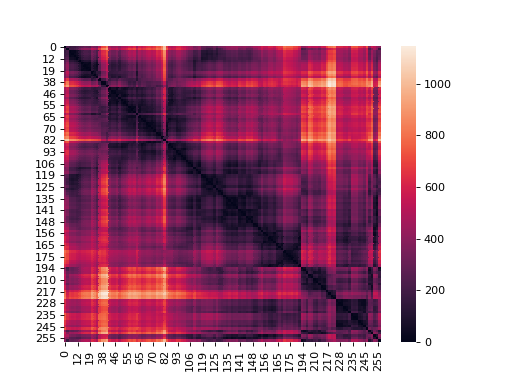

In [365]:
pl.figure()
sns.heatmap(dist_matrix)

#### For each cell, look at correlation between its distances to all other cells vs. correlation between its activity to all other cells' activity

In [371]:
print len(roi_list)
print np.sqrt(len(roi_list))

127
11.2694276696


In [374]:
corr = tstats.corr(method='pearson')


<IPython.core.display.Javascript object>


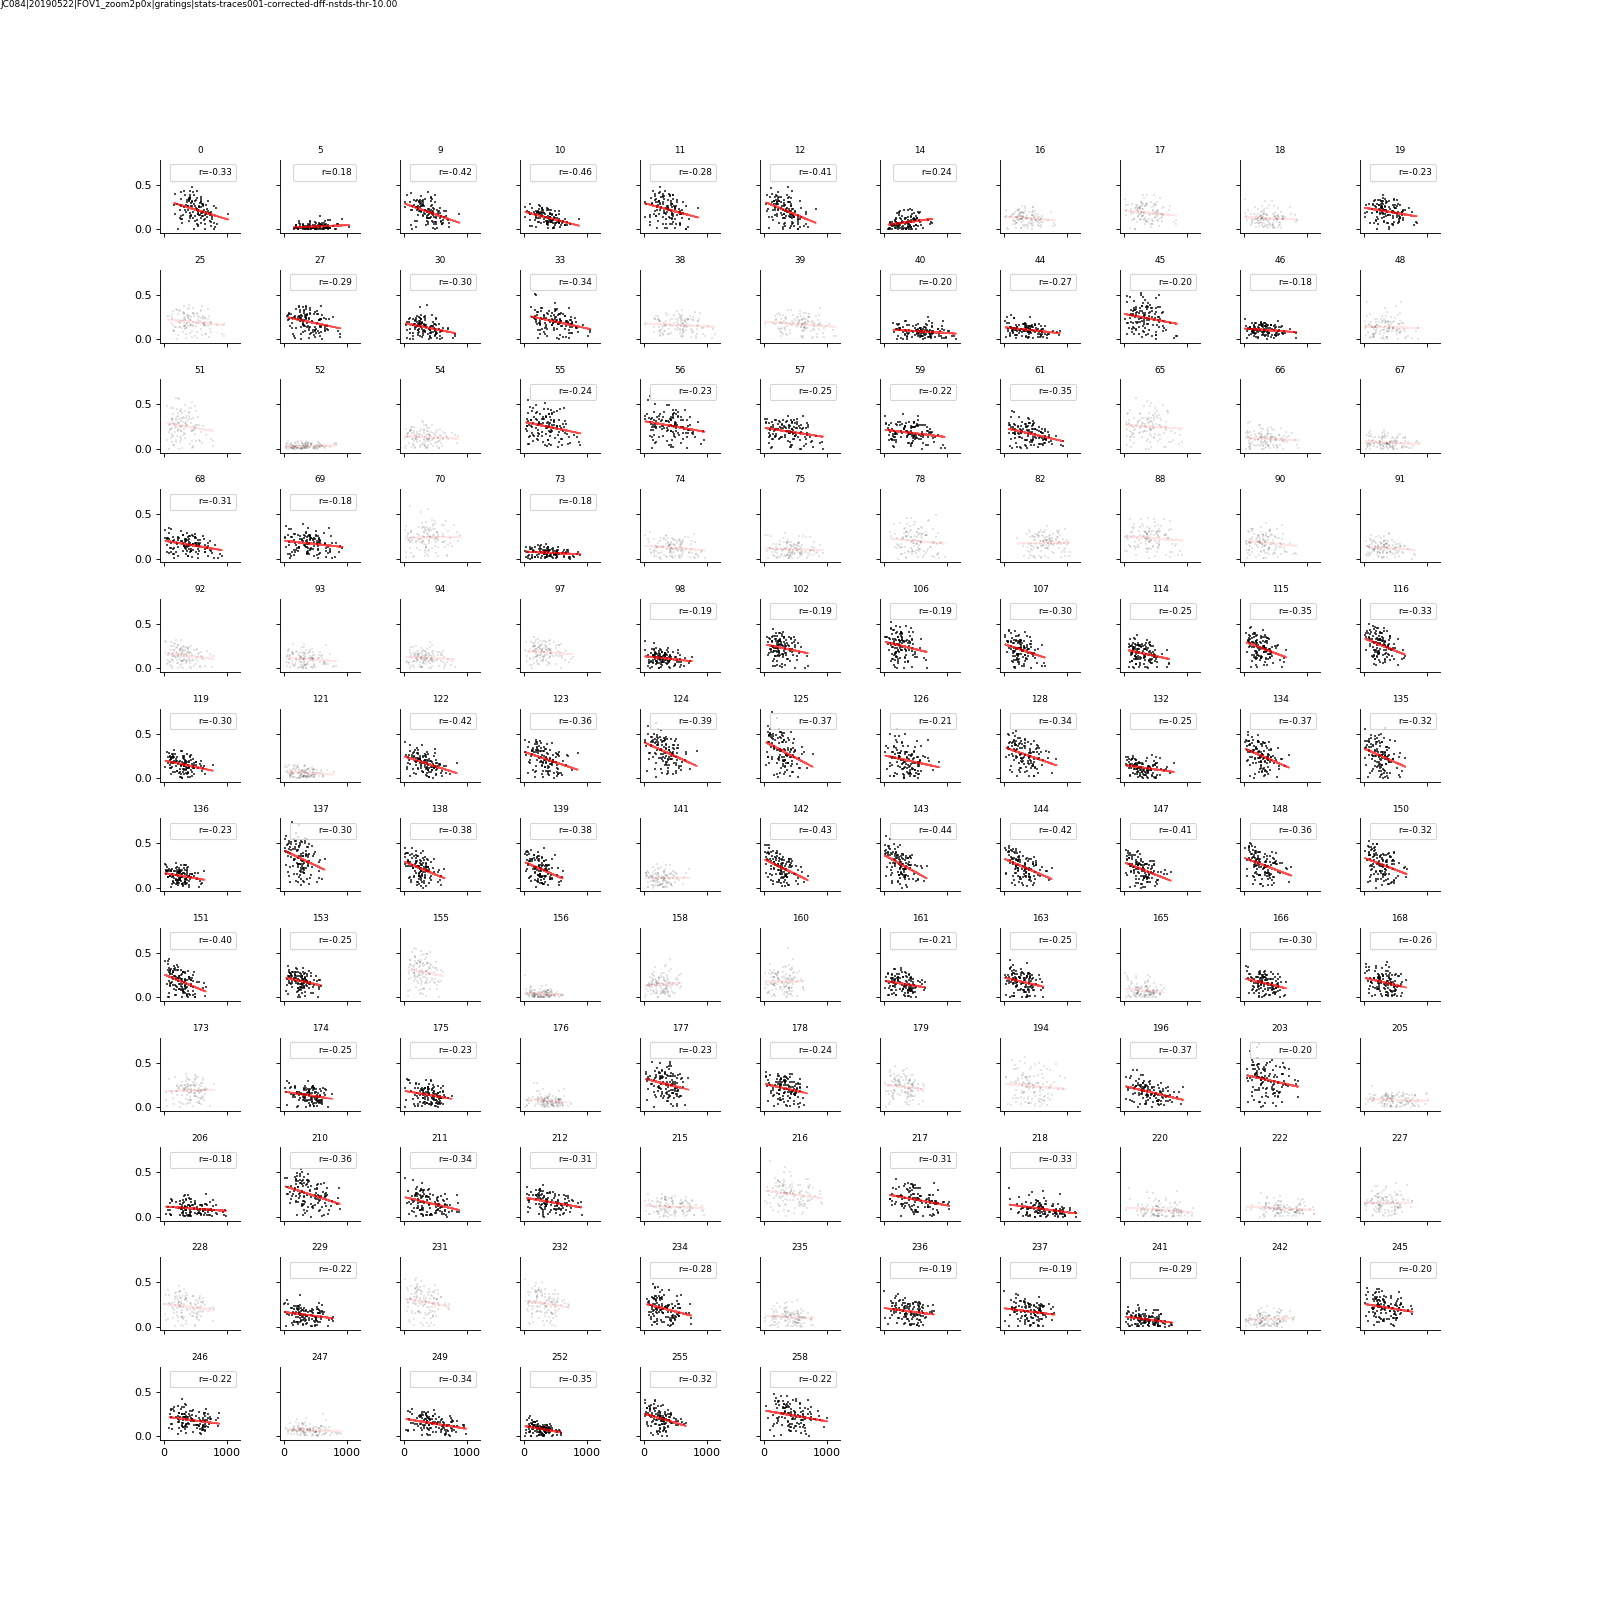

In [375]:
nplots = 30

nr = 12
nc = 11

coeffs = []
fig, axes = pl.subplots(nr, nc, sharex=True, sharey=True, figsize=(20,20))
fig.patch.set_alpha(1)
ai = 0
for roi in roi_list: #[0:nplots]:
    ax = axes.flat[ai]
#     g = ucorr.groupby(['row']).get_group(roi)
#     ixs = g.index.tolist()
#     curr_dists = pwdists[ixs]
#     curr_corrs = g['value'].values
#     print len(curr_corrs)
    currp = currpos.loc[roi]

    curr_dists = (currpos[['ap_pos', 'ml_pos']] - np.array(currp)).pow(2).sum(1).pow(0.5).values
    ixs = np.array([i for i, r in enumerate(currpos.index.tolist()) if r != roi])
    curr_dists = curr_dists[ixs]
    
    curr_corrs = np.abs(corr[roi].values)
    ixs = np.array([i for i, r in enumerate(corr[roi].index.tolist()) if r!= roi])
    curr_corrs = curr_corrs[ixs]

    fitv, regr = fit_linear_regr(curr_dists, curr_corrs, return_regr=True)
    r, p = spstats.pearsonr(curr_dists, curr_corrs)
    label = 'r=%.2f' % r
    ax.plot(0, 0, alpha=0, label=label)
    if p < 0.05:
        ax.legend(loc='upper right', fontsize=8)
        alpha=0.7
        coeffs.append(r)
    else:
        alpha=0.1
    
    ax.scatter(curr_dists, curr_corrs, marker='+', s=1, c='k', alpha=alpha)
    ax.plot(curr_dists, fitv, 'r', alpha=alpha)
    ax.set_title(roi, fontsize=8)

    sns.despine(ax=ax)
    ai += 1

pl.subplots_adjust(wspace=0.5, hspace=0.5, left=0.1, right=0.9, top=0.9, bottom=0.1)
for ax in axes.flat[ai:]:
    ax.axis('off')
    
    
label_figure(fig, '|'.join([animalid, session, fov, 'gratings', stats_desc]))
pl.savefig(os.path.join(aggregate_dir, 'pw-distances_vs_cell-cell-corrs_example.png'))

####  Look at distn of corr coeffs

<IPython.core.display.Javascript object>


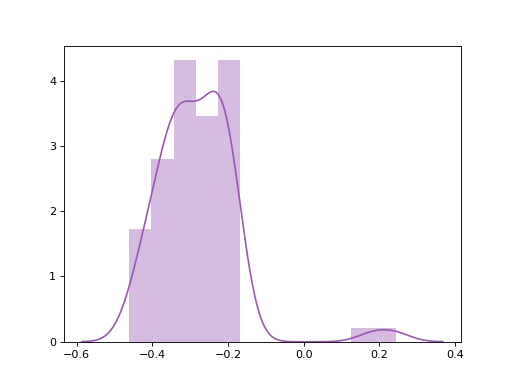

In [376]:
fig, ax = pl.subplots()
sns.distplot(coeffs, ax=ax)

#### Grab upper diagonal of correlations

In [202]:
ucorr = corr.where(np.triu(np.ones(corr.shape), 1).astype(np.bool))
ucorr = ucorr.stack().reset_index()
ucorr.shape
ucorr.columns = ['row', 'col', 'value']

#### Calculate pairwise distances

In [ ]:
pwdists = pdist(currpos[['ml_pos', 'ap_pos']], metric='euclidean')

<IPython.core.display.Javascript object>


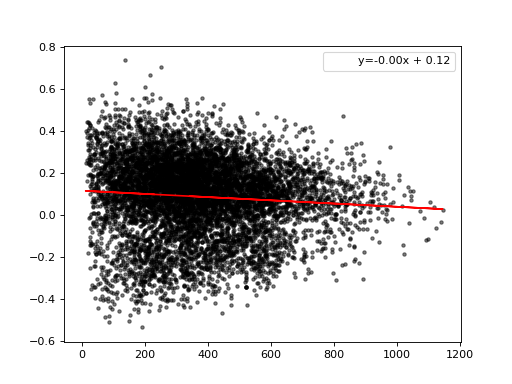

In [378]:

xv = pwdists
yv = ucorr['value']#**2. #np.abs(ucorr['value'].values)

fitv, regr = fit_linear_regr(xv, yv, return_regr=True)

fig, ax = pl.subplots() #pl.figure()
ax.scatter(xv, yv, marker='.', alpha=0.5, c='k', label=None)
ax.plot(xv, fitv, 'r')
ax.plot(0,0, alpha=0, label='y=%.2fx + %.2f' % (float(regr.coef_), float(regr.intercept_)))

ax.legend(loc='upper right')

<IPython.core.display.Javascript object>


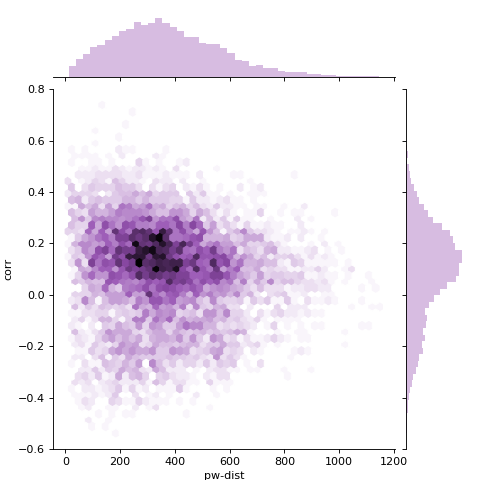

In [239]:
g = sns.jointplot(xv, yv, kind='hex')
g.set_axis_labels('pw-dist', 'corr')

In [462]:
reload(util)

<module 'pipeline.python.classifications.experiment_classes' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py'>

# Aggregate all data

In [13]:
corr_method = 'pearson'

# Correlate shared ROIs

In [14]:
corrcoef_fpath = os.path.join(aggregate_dir, 'cell-dist_v_trial-corrs_corrcoef-%s.pkl' % corr_method)

do_correlations = False
if os.path.exists(corrcoef_fpath):
    print("... loading existing results")
    try:
        with open(corrcoef_fpath, 'rb') as f:
            df = pkl.load(f)
    except Exception as e:
        do_correlations = True
else:
    do_correlations = True

... loading existing results


In [15]:
if do_correlations:
    df_list = []
    for (visual_area, animalid, session, fov), g in sdata.groupby(['visual_area', 'animalid', 'session', 'fov']):
        S = util.Session(animalid, session, fov)
        roi_list = S.get_all_responsive_cells(traceid=traceid, response_type=response_type,
                                          responsive_test=responsive_test, responsive_thr=responsive_thr, fit_thr=0.5)


        currpos = posdf.groupby(['animalid', 'session', 'fov']).get_group((animalid, session, fov))
        currpos = currpos[currpos['index'].isin(roi_list)]
        currpos.index = currpos['index']
        _ =currpos.pop('index')
        currpos = currpos[['ap_pos', 'ml_pos']]

        for expname, exp in S.experiments.items():
            if 'retino' in expname:
                continue
            # if experiment == 'gratings':
            #     ex = util.Gratings(animalid, session, fov, traceid=traceid)
            # elif experiment == 'blobs':
            #     ex = util.Objects(animalid, session, fov, traceid=traceid)
            # else:
            #     ex = util.ReceptiveFields('rfs', animalid, session, fov, traceid=traceid)
            #S.experiments[experiment].get_trial_metrics()
            stats = exp.get_trial_metrics() #ex.get_trial_metrics()
            tstats = stats[roi_list]
        #     roi_list, nrois_total = ex.get_responsive_cells(responsive_test=responsive_test, 
        #                                                     responsive_thr=responsive_thr, 
        #                                                     n_stds=n_stds)
        #     tstats = tstats[roi_list]

            #pwdists = pdist(currpos[['ml_pos', 'ap_pos']], metric='euclidean')
            corr = tstats.corr(method=corr_method)

            coeffs=[]; pvals=[];
            for roi in roi_list:

                # Get distance of each cell to current cell
                currp = currpos.loc[roi]
                curr_dists = (currpos[['ap_pos', 'ml_pos']] - np.array(currp)).pow(2).sum(1).pow(0.5).values
                ixs = np.array([i for i, r in enumerate(currpos.index.tolist()) if r != roi])
                curr_dists = curr_dists[ixs]

                # Get correlation between current cell's trial values and all other cells' trial values
                curr_corrs = np.abs(corr[roi].values)
                ixs = np.array([i for i, r in enumerate(corr[roi].index.tolist()) if r!= roi])
                curr_corrs = curr_corrs[ixs]

                #fitv, regr = fit_linear_regr(curr_dists, curr_corrs, return_regr=True)
                r, p = spstats.pearsonr(curr_dists, curr_corrs)

                coeffs.append(r)
                pvals.append(r)

            df_list.append( pd.DataFrame({'corrcoef': coeffs,
                                         'pval': pvals,
                                         'visual_area': [visual_area for _ in range(len(roi_list))],
                                         'animalid': [animalid for _ in range(len(roi_list))],
                                         'fov': [fov for _ in range(len(roi_list))],
                                          'session': [session for _ in range(len(roi_list))],
                                          'experiment': [expname for _ in range(len(roi_list))]},
                                        index=roi_list) )

df = pd.concat(df_list, axis=0).reset_index()
print df.shape
df['cell'] = df.pop('index')
del df_list

with open(corrcoef_fpath, 'wb') as f:
    pkl.dump(df, f, protocol=pkl.HIGHEST_PROTOCOL)
    

NameError: name 'df_list' is not defined

# Plot

In [17]:
visual_areas = ['V1', 'Lm', 'Li']
colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

In [22]:
data_identifier = '|'.join([fov_type, traceid, stats_desc])
print data_identifier

zoom2p0x|traces001|stats-traces001-corrected-dff-nstds-thr-10.00


## Plot corr coefs by visual area (aggregate across experiments)

<IPython.core.display.Javascript object>


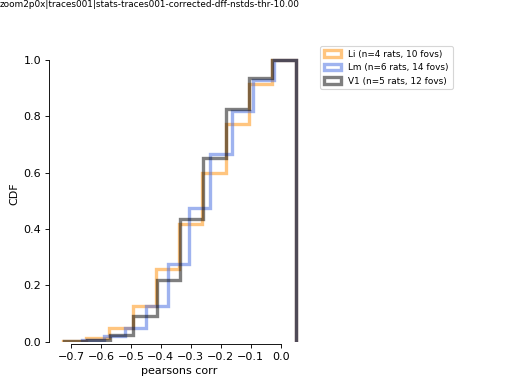

In [24]:
cdf = True
fig, ax = pl.subplots()
fig.patch.set_alpha(1)

for visual_area, tmpd in df.groupby(['visual_area']):
    g = tmpd[tmpd['pval'] < 0.05]

    nrats = len(g['animalid'].unique())
    values = g['corrcoef'].values
    weights = np.ones_like(values)/float(len(values))

    nfovs = len(g.groupby(['animalid', 'session', 'fov']).groups)
    label = '%s (n=%i rats, %i fovs)' % (visual_area, nrats, nfovs)

    ax.hist(values, 
            cumulative=cdf,
            label=label,
            color=area_colors[visual_area],
            histtype='step', alpha=0.5, lw=3,
            normed=0, weights=weights)

    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)

        
sns.despine(ax=ax, trim=True, offset=2)
ax.set_xlabel('pearsons corr')
if cdf:
    ax.set_ylabel('CDF')
else:
    ax.set_ylabel('fraction')
    
pl.subplots_adjust(right=0.6, left=0.1, wspace=0.2)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(aggregate_dir, 'corr_cell-dist_vs_trial-resp_all-experiments.png'))

### Separate by experiment type

<IPython.core.display.Javascript object>


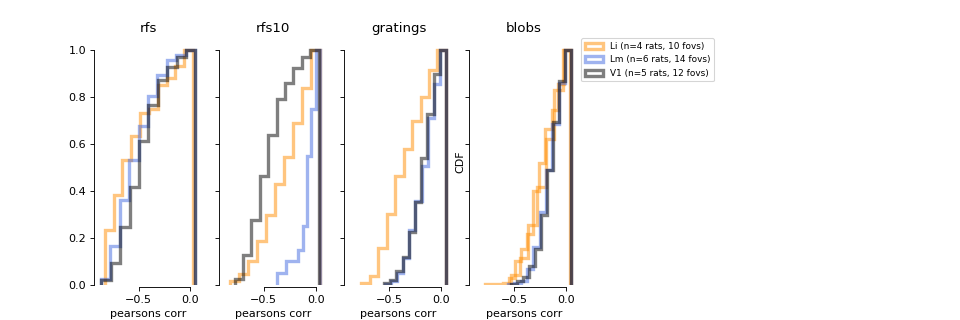

In [33]:
cdf = True
fig, axes = pl.subplots(1, 4, figsize=(12,4), sharex=True, sharey=True)
for visual_area, tmpd in df.groupby(['visual_area']):
    g = tmpd[tmpd['pval'] < 0.05]

    nrats = len(g['animalid'].unique())

    for i, (experiment, gg) in enumerate(g.groupby(['experiment'])):
        if experiment =='rfs':
            ax = axes[0]
        elif experiment == 'rfs10':
            ax = axes[1]
        elif experiment == 'gratings':
            ax = axes[2]
        elif experiment == 'blobs':
            ax = axes[3]

        values = gg['corrcoef'].values
        weights = np.ones_like(values)/float(len(values))
        
        nfovs = len(g.groupby(['animalid', 'session', 'fov']).groups)
        if i==0:
            label = '%s (n=%i rats, %i fovs)' % (visual_area, nrats, nfovs)
        else:
            label = None
        ax.hist(values, 
                cumulative=cdf,
                label=label,
                color=area_colors[visual_area],
                histtype='step', alpha=0.5, lw=3,
                normed=0, weights=weights)

        ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
        ax.set_title(experiment)

        
for ax in axes:
    sns.despine(ax=ax, trim=True, offset=2)
    ax.set_xlabel('pearsons corr')
if cdf:
    ax.set_ylabel('CDF')
else:
    ax.set_ylabel('fraction')
    
pl.subplots_adjust(right=0.6, left=0.1, wspace=0.2)


In [72]:
both_rfs = [k for k, g in sdata.groupby(['animalid', 'session', 'fov']) \
     if 'rfs' in g['experiment'].unique() and 'rfs10' in g['experiment'].unique()]

In [73]:
both_rfs

[('JC085', '20190622', 'FOV1_zoom2p0x'),
 ('JC091', '20190602', 'FOV1_zoom2p0x'),
 ('JC097', '20190613', 'FOV1_zoom2p0x'),
 ('JC097', '20190616', 'FOV1_zoom2p0x')]

# Plot active cells per experiment type


In [27]:
corrcoef_fpath = os.path.join(aggregate_dir, 'cell-dist_v_cond-corrs_corrcoef-%s_active-cells.pkl' % corr_method)
with open(corrcoef_fpath, 'rb') as f:
    df = pkl.load(f)

<IPython.core.display.Javascript object>


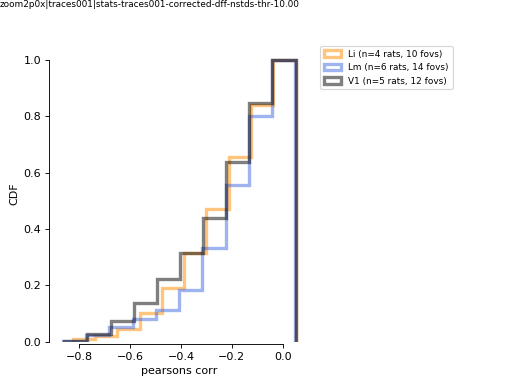

In [28]:
cdf = True
fig, ax = pl.subplots()
fig.patch.set_alpha(1)

for visual_area, tmpd in df.groupby(['visual_area']):
    g = tmpd[tmpd['pval'] < 0.05]

    nrats = len(g['animalid'].unique())
    values = g['corrcoef'].values
    weights = np.ones_like(values)/float(len(values))

    nfovs = len(g.groupby(['animalid', 'session', 'fov']).groups)
    label = '%s (n=%i rats, %i fovs)' % (visual_area, nrats, nfovs)

    ax.hist(values, 
            cumulative=cdf,
            label=label,
            color=area_colors[visual_area],
            histtype='step', alpha=0.5, lw=3,
            normed=0, weights=weights)

    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)

        
sns.despine(ax=ax, trim=True, offset=2)
ax.set_xlabel('pearsons corr')
if cdf:
    ax.set_ylabel('CDF')
else:
    ax.set_ylabel('fraction')
    
pl.subplots_adjust(right=0.6, left=0.1, wspace=0.2)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(aggregate_dir, 'corr_cell-dist_vs_trial-resp_all-experiments_active-cells-per.png'))

<IPython.core.display.Javascript object>


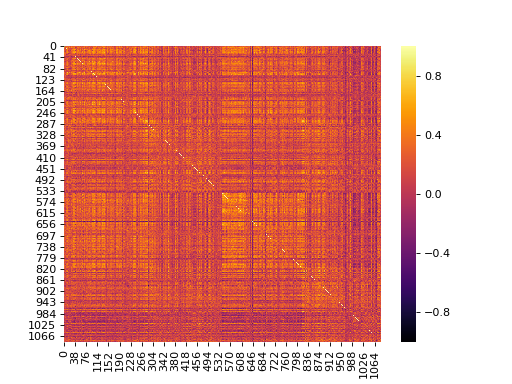

In [40]:
corr_trials = tstats.T.corr()
pl.figure()
sns.heatmap(corr_trials, cmap='inferno', vmin=-1, vmax=1)

<IPython.core.display.Javascript object>


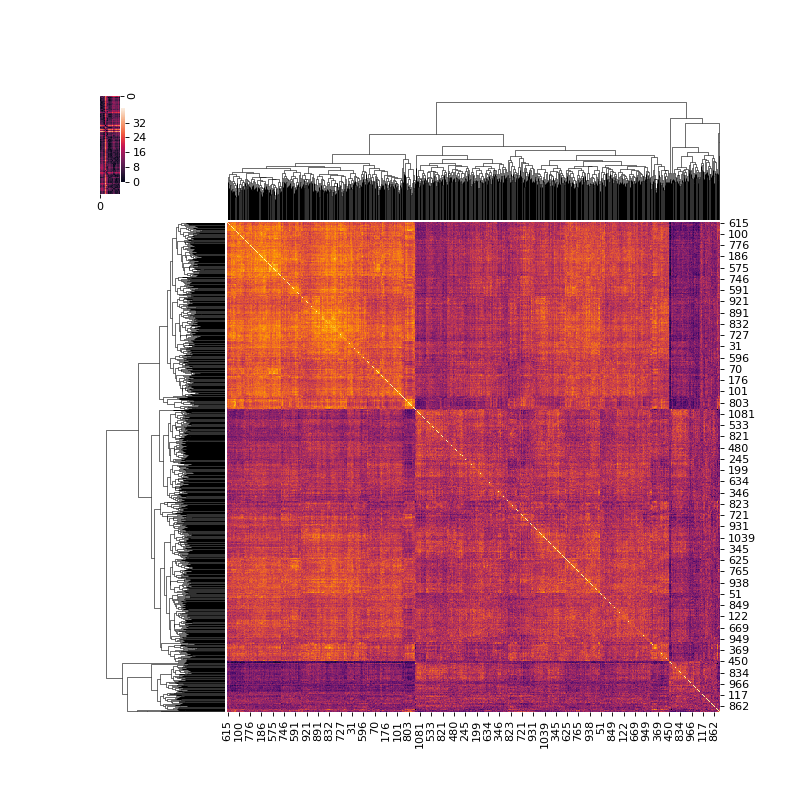

In [45]:
sns.clustermap(corr_trials, cmap='inferno', z_score=None)